In [29]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
import fastai
from fastai import * 
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *

import pandas as pd
import numpy as np

fastai.version.__version__

'1.0.36.post1'

In [31]:
# make sure CUDA is available and enabled
print('CUDA enabled:',torch.cuda.is_available()) 
print('CUDNN enabled:', torch.backends.cudnn.enabled)

CUDA enabled: True
CUDNN enabled: True


In [32]:
def recreate_directory(directory):
    !rm -R {directory} 2>nul
    !mkdir {directory}

# Dataset preprocessing

In [33]:
input_path ='/kaggle/input'
work_dir = '/kaggle/working'
train_dir = f"{input_path}/train"
train_labels = f"{input_path}/train.csv"
test_dir = f"{input_path}/test"
workdir_train_labels = f"{work_dir}/train.csv"
workdir_train = f"{work_dir}/train"

In [34]:
labels_df = pd.read_csv(train_labels)
print(labels_df.shape)
labels_df = labels_df.sample(frac=0.02)
print(labels_df.shape)

(25361, 2)
(507, 2)


In [40]:
labels_df.to_csv(workdir_train_labels, index=False)

In [35]:
recreate_directory(workdir_train)

In [37]:
recreate_directory(workdir_train)
for img in labels_df['Image']:
    !cp {train_dir}/{img} {workdir_train}/{img}

## Train model

In [38]:
SZ = 224
BS = 64
NUM_WORKERS = 0
SEED=0
arch = models.resnet18

In [41]:
data = (
    ImageDataBunch
        .from_csv(path=workdir_train, csv_labels=workdir_train_labels, ds_tfms=get_transforms(), 
                  size=SZ,num_workers=NUM_WORKERS, test=test_dir)
#         .databunch(bs=BS, num_workers=NUM_WORKERS, path='../input')
#         .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
#         .normalize(imagenet_stats)
)

In [ ]:
# data.show_batch(rows=3, fig_size=(SZ, SZ))

# Learning rate

In [42]:
learn = create_cnn(data, arch, metrics=accuracy, model_dir=f"{work_dir}/model")

In [43]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


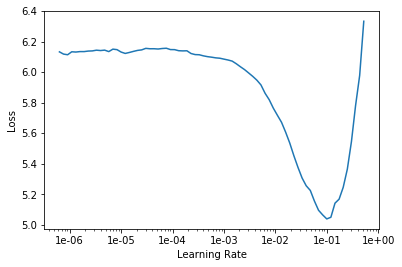

In [44]:
learn.recorder.plot()

# Precompute

In [45]:
lr_rate = 1e-2
learn = create_cnn(data, arch, metrics=accuracy, model_dir=f"{work_dir}/model2")
learn.freeze_to(-1)

In [46]:
learn.fit(1, lr_rate)

epoch,train_loss,valid_loss,accuracy
1,5.729465,7.710929,0.039604


In [47]:
# learn few epochs with unfreeze
learn.unfreeze()

In [48]:
learn.fit(5, [lr_rate/100, lr_rate/10, lr_rate])

epoch,train_loss,valid_loss,accuracy
1,4.870755,2.911143,0.594059
2,4.381713,6.916470,0.158416
3,4.021190,1.456107,0.752475
4,3.683061,1.912359,0.643564
5,3.345231,2.592554,0.504951


# Prediction

In [49]:
log_preds,y = learn.TTA()

In [63]:
log_preds, y = learn.get_preds(DatasetType.Test)

In [76]:
preds = torch.cat((log_preds, torch.ones_like(log_preds[:, :1])), 1)

In [79]:
preds.shape

torch.Size([7960, 234])

# Submission - for now random submission

In [ ]:
train_set = pd.read_csv(f"{input_path}/train.csv")
train_set.head()

In [ ]:
unique_labels = train_set['Id'].unique()
unique_labels.shape

In [ ]:
submission = pd.read_csv(f"{input_path}/sample_submission.csv")
submission.head()

In [ ]:
print(' '.join(np.append(np.random.choice(unique_labels, 4), 'new_whale')))


In [ ]:
submission['Id'] = submission['Id'].apply(lambda x : ' '.join(np.append(np.random.choice(unique_labels, 4), 'new_whale')))

In [ ]:
print(submission.head())
print(submission.shape)

In [ ]:
submission.to_csv('submission.csv', index=False)